## The project: Predict travel insurance claims

We use the "Travel Insurance" dataset from Zahier Nasrudin, published on Kaggle (Nasrudin, 2019). It contains data from a third-party insurance servicing company based in Singapore. &nbsp;

The target in the data is a binary variable indicating whether the policy holder filed a claim against the insurance company. This target will be predicted using as features characteristics of the travel insurance holders, attributes of the associated trips, as well as attributes of the insurance products purchased. Specifically, the used features are: agency, agency type, travel insurance product type (e.g. cancellation, rental vehicel, ticket protector), distribution channel (online, offline), country of destination, trip duration, net sales, commision, as well as gender and age of the policy holder.
&nbsp;

Link to data: https://www.kaggle.com/datasets/mhdzahier/travel-insurance

In [1]:
#!pip install sagemaker

In [2]:
# For .info() method to run below, need to older version of numpy
!pip install numpy==1.18.1

  Using cached numpy-1.18.1-cp37-cp37m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
import sagemaker
import pandas as pd
import numpy as np
from platform import python_version
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import os
import sagemaker
import boto3
from sagemaker.sklearn.estimator import SKLearn

In [4]:
python_version(), np.__version__

('3.7.10', '1.18.1')

### (a) Download data from Kaggle into Jupyter NB instance folder, load data into Jupyter NB environment

(1) Download the authentication json file ('kaggle.json') from Kaggle & upload it to the notebook file directory <br>
(2) Run the following code in bash terminal to download the travel insurance dataset from Kaggle

In [5]:
# pip install kaggle
# mkdir ~/.kaggle
# cp kaggle.json ~/.kaggle/
# chmod 600 .kaggle/kaggle.json
# cd ml_eng_capstone
# kaggle datasets download -d mhdzahier/travel-insurance

Load data persisted on Jupyter notebook instance into Jupyter notebook environment

In [6]:
with zipfile.ZipFile('travel-insurance.zip', 'r') as zip_ref:
    zip_ref.extractall()
travel_insurance_df = pd.read_csv('travel insurance.csv')

### (b) Inspect & clean data

In [7]:
travel_insurance_df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [8]:
travel_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [9]:
travel_insurance_df.isnull().sum()

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64

Describe numerical values:

In [10]:
print('Duration:')
print(travel_insurance_df['Duration'].describe())
print()
print('Commision (in value):')
print(travel_insurance_df['Commision (in value)'].describe())
print()
print('Age:')
print(travel_insurance_df['Age'].describe())

Duration:
count    63326.000000
mean        49.317074
std        101.791566
min         -2.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64

Commision (in value):
count    63326.000000
mean         9.809992
std         19.804388
min          0.000000
25%          0.000000
50%          0.000000
75%         11.550000
max        283.500000
Name: Commision (in value), dtype: float64

Age:
count    63326.000000
mean        39.969981
std         14.017010
min          0.000000
25%         35.000000
50%         36.000000
75%         43.000000
max        118.000000
Name: Age, dtype: float64


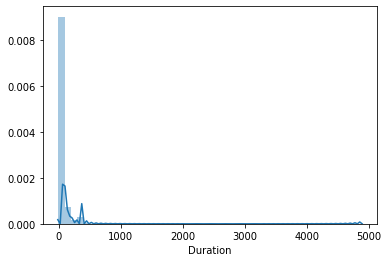

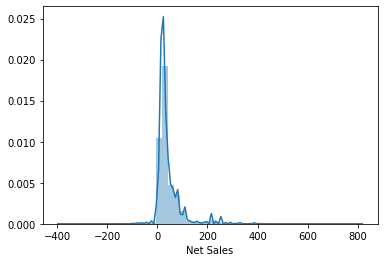

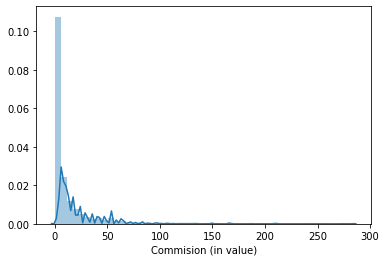

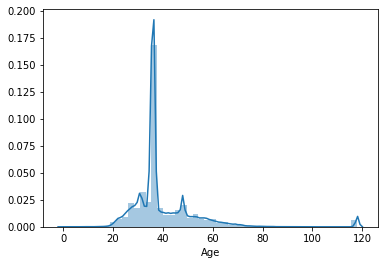

In [11]:
travel_insurance_sub = travel_insurance_df[['Duration', 'Net Sales', 'Commision (in value)', 'Age']]
for i, col in enumerate(travel_insurance_sub):
    plt.figure(i)
    sns.distplot(travel_insurance_sub[col])

Duration: Drop rows with negative values

In [12]:
len(travel_insurance_df[travel_insurance_df['Duration']<0])

5

In [13]:
index_neg_duration = travel_insurance_df[travel_insurance_df['Duration']<0].index
travel_insurance_df.drop(index_neg_duration, inplace=True)
travel_insurance_df = travel_insurance_df.reset_index().drop(labels='index', axis=1)
travel_insurance_df.shape

(63321, 11)

Duration: Drop rows with extremely high values (upward outliers)

In [14]:
pd.set_option('display.max_rows', 50)
travel_insurance_df['Duration'].value_counts().sort_index(ascending = False).head(40)

4881    1
4857    1
4847    1
4844    1
4831    1
4829    1
4815    1
4784    1
4738    1
4736    1
4685    1
4652    1
4609    1
4580    1
740     1
547     1
545     1
531     1
529     2
519     1
512     1
508     2
497     1
494     1
490     1
488     1
487     1
478     1
474     1
472     2
466     3
465     1
463     2
461     1
459     1
457     2
456     2
450     1
448     2
445     1
Name: Duration, dtype: int64

In [15]:
index_high_duration = travel_insurance_df[travel_insurance_df['Duration']>500].index
travel_insurance_df.drop(index_high_duration, inplace=True)
travel_insurance_df = travel_insurance_df.reset_index().drop(labels='index', axis=1)

In [16]:
travel_insurance_df.shape

(63297, 11)

In [17]:
travel_insurance_df['Age'].value_counts().sort_index(ascending = False).head(10)

118    979
88       4
87       8
86       4
85       9
84      20
83      18
82      17
81      23
80      21
Name: Age, dtype: int64

Upward outliers in age (118) will be replaced by next best "realistic" value (88), effectively introducing an age cap at 88

In [18]:
travel_insurance_df['Age'] = np.where(travel_insurance_df['Age'] == 118, 88, travel_insurance_df['Age'])

Replace NAs (only in Gender column) by string 'UNKNOWN'

In [19]:
travel_insurance_df.fillna('UNKNOWN',inplace=True)

In [20]:
##Remove rows with missing data:
#travel_insurance_df = travel_insurance_df.dropna()
#travel_insurance_df = travel_insurance_df.reset_index().drop(labels='index', axis=1)

Overview over data:

In [21]:
no_instances = travel_insurance_df.shape[0]
no_features = len(travel_insurance_df.columns) - 1
target_shares = round(travel_insurance_df['Claim'].value_counts()/len(travel_insurance_df),3)
print("No. of instances: " + f"{no_instances:,}")
print("No. of columns: " + str(no_features))
print("Share of targets: \n" + str(target_shares))
travel_insurance_df.head()

No. of instances: 63,297
No. of columns: 10
Share of targets: 
No     0.985
Yes    0.015
Name: Claim, dtype: float64


,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,UNKNOWN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,UNKNOWN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,UNKNOWN,41


In [22]:
## Pie chart
#count_agency = pd.DataFrame(travel_insurance_df['Agency'].value_counts())
#count_agency['Count'] = count_agency['Agency']
#count_agency['Agency'] = count_agency.index
#count_agency.reset_index(inplace=True)
#count_agency.drop(columns='index', inplace=True)
#count_agency.groupby(['Agency']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%', title='Points Scored by Team')

In [23]:
feat_list = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']
num_rows = len(travel_insurance_df)
for feat in feat_list:
    value_counts_df = pd.DataFrame(travel_insurance_df[feat].value_counts())
    value_counts_df['Count'] = value_counts_df[feat]
    value_counts_df[feat] = value_counts_df.index
    value_counts_df.reset_index(inplace=True)
    value_counts_df.drop(columns='index', inplace=True)
    value_counts_df['Share (in %)'] = round(value_counts_df['Count']/num_rows, 4)*100
    print(value_counts_df.head(25))
    print()

   Agency  Count  Share (in %)
0     EPX  35119         55.48
1     CWT   8580         13.56
2     C2B   8260         13.05
3     JZI   6324          9.99
4     SSI   1042          1.65
5     JWT    749          1.18
6     RAB    725          1.15
7     LWC    686          1.08
8     TST    528          0.83
9     KML    392          0.62
10    ART    331          0.52
11    CCR    194          0.31
12    CBH    101          0.16
13    TTW     98          0.15
14    CSR     86          0.14
15    ADM     82          0.13

     Agency Type  Count  Share (in %)
0  Travel Agency  45866         72.46
1       Airlines  17431         27.54

  Distribution Channel  Count  Share (in %)
0               Online  62190         98.25
1              Offline   1107          1.75

                            Product Name  Count  Share (in %)
0                      Cancellation Plan  18630         29.43
1               2 way Comprehensive Plan  13158         20.79
2        Rental Vehicle Excess Insuran

### (c) Prep data, save on Jupyter NB instance, upload to S3

Recode target ('Claim') into numerical variable:

In [24]:
dict_label = {'Yes' : 1, 'No' : 0}
travel_insurance_df['Claim'] = travel_insurance_df['Claim'].replace(dict_label)

Correlation analysis of categorical features

In [25]:
#pd.crosstab(travel_insurance_df['Agency'], travel_insurance_df['Agency Type'])

Replace categorical features through one-hot encoding:

In [26]:
travel_insurance_df.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

Categorical features are transformed into dummy variables. Given the non-ordinal nature of the categorical features ('Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination', 'Gender') we use one-hot encoding instead of label encoding. The last dummy column of each categorical feature is excluded to avoid perfect collinearity.

In [27]:
def one_hot(df):
    #Function performs one-hot encoding with features of datatype object (string)lit
    #Last dummy column of each categorical feature is excluded to avoid perfect collinearity
    #NOTE: Categorical features already encoded as integers are NOT identified by this function!
    dtypes_ser = df.dtypes
    dtypes_df = dtypes_ser.to_frame().reset_index()
    dtypes_df = dtypes_df.rename(columns = {'index':'column', 0:'dtype'})
    categ_list = list(dtypes_df['column'][dtypes_df['dtype']=='object'])
    for feat in categ_list:
        one_hot = pd.get_dummies(df[feat], prefix=feat, drop_first=True)
        df = df.join(one_hot)
        df.drop(feat, inplace=True, axis=1)
    return df

In [28]:
travel_insurance_df = one_hot(travel_insurance_df)

In [29]:
travel_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63297 entries, 0 to 63296
Columns: 197 entries, Claim to Gender_UNKNOWN
dtypes: float64(2), int64(3), uint8(192)
memory usage: 14.0 MB


Train-test split <br>
(Note: test data is without label)

In [128]:
travel_insurance_df_train, travel_insurance_df_test = train_test_split(travel_insurance_df, test_size = 0.2, 
                                                                 stratify = travel_insurance_df['Claim'], 
                                                                 shuffle = True, 
                                                                 random_state = 1)
travel_insurance_df_test_x = travel_insurance_df_test.drop(labels='Claim', axis = 1)
travel_insurance_df_test_y = pd.DataFrame(travel_insurance_df_test['Claim'])

In [31]:
travel_insurance_df_train.shape, travel_insurance_df_test_x.shape

((50637, 197), (12660, 196))

Save train and test data to S3

In [32]:
sm_session = sagemaker.Session()
sm_role = sagemaker.get_execution_role()
bucket = sm_session.default_bucket()

In [33]:
sm_session, sm_role, bucket

(<sagemaker.session.Session at 0x7f4c22807f10>,
 'arn:aws:iam::821983426621:role/service-role/AmazonSageMaker-ExecutionRole-20220516T003179',
 'sagemaker-eu-central-1-821983426621')

In [34]:
data_dir = '../ml_eng_capstone/data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [35]:
travel_insurance_df_train.to_csv(data_dir + '/' + 'train.csv', header = False, index = False)
travel_insurance_df_test_x.to_csv(data_dir + '/' + 'test.csv', header = False, index = False)

In [36]:
prefix = 'travel_insurance_claim_data'
train_path_s3 = sm_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_path_s3 = sm_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

In [37]:
# Overview on files on S3
bucket_list = []
for i in boto3.resource('s3').Bucket(bucket).objects.all():
    bucket_list.append(i)
bucket_list

[s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='travel_insurance_claim_data/test.csv'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='travel_insurance_claim_data/train.csv')]

In [38]:
#Delete data files in s3://sagemaker-us-east-1-786251868139/travel_insurance_claim_data/
#boto3.resource('s3').Bucket(bucket).objects.all().delete()

### (d)	Train Random Forest w custom scikit-learn estimator (baseline A)

In [39]:
!pygmentize source/train_rf.py

from __future__ import print_function
import argparse
import os
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier

def model_fn(model_dir):
    
    # Load model from the model_dir; this is the same model that is saved in the main if statement
    
    print("Loading model.")
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    return model


if __name__ == '__main__':
    
    # During a training job, all of the model parameters and training parameters are sent as arguments when this script is executed
    
    # Set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SM_OUTPUT_DATA_DIR: path to write output artifacts to (checkpoints, graphs, and other files to save, not including model artifacts):
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    # SM_OUTPUT_DATA_DIR: path to write model artifacts to:
 

In [40]:
est_rf_base = SKLearn(entry_point = 'train_rf.py',
                       source_dir = 'source',
                       role = sm_role,
                       framework_version = '0.23-1',
                       py_version = 'py3',
                       instance_count = 1,
                       instance_type = 'ml.m4.xlarge',
                       output_path = 's3://{}/{}/output'.format(bucket, prefix),
                       sagemaker_session = sm_session
                       #hyperparameters = {'n_estimators':100, 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':None, 'max_leaf_nodes':None}
                     )

In [41]:
est_rf_base.fit({'train' : train_path_s3})

2022-05-18 06:05:07 Starting - Starting the training job...
2022-05-18 06:05:34 Starting - Preparing the instances for trainingProfilerReport-1652853907: InProgress
.........
2022-05-18 06:06:54 Downloading - Downloading input data...
2022-05-18 06:07:34 Training - Downloading the training image......
2022-05-18 06:08:34 Training - Training image download completed. Training in progress.2022-05-18 06:08:27,201 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-05-18 06:08:27,205 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-18 06:08:27,217 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-05-18 06:08:27,576 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-18 06:08:27,599 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-18 06:08:27,615 sagemaker-training-toolkit INFO     No GPUs detected (

### (e) Train SVM w custom scikit-learn estimator (baseline B)

In [ ]:
!pygmentize source/train_svm.py

In [43]:
est_svm_base = SKLearn(entry_point = 'train_svm.py',
                       source_dir = 'source',
                       role = sm_role,
                       framework_version = '0.23-1',
                       py_version = 'py3',
                       instance_count = 1,
                       instance_type = 'ml.m4.xlarge',
                       output_path = 's3://{}/{}/output'.format(bucket, prefix),
                       sagemaker_session = sm_session
                       #hyperparameters = {'C':1, 'gamma':0.01}
                     )

In [44]:
est_svm_base.fit({'train' : train_path_s3})

2022-05-18 06:35:23 Starting - Starting the training job...
2022-05-18 06:35:48 Starting - Preparing the instances for trainingProfilerReport-1652855723: InProgress
.........
2022-05-18 06:37:07 Downloading - Downloading input data...
2022-05-18 06:37:47 Training - Downloading the training image......
2022-05-18 06:38:47 Training - Training image download completed. Training in progress.2022-05-18 06:38:44,402 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-05-18 06:38:44,406 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-18 06:38:44,417 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-05-18 06:38:44,783 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-18 06:38:44,797 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-18 06:38:44,811 sagemaker-training-toolkit INFO     No GPUs detected (

### (f) Test baseline models with batch transform (SageMaker Python SDK)

#### (f-1) Test RF model (baseline)

##### Batch transform with SageMaker SDK (needs estimator_obj in notebook environment)

In [45]:
transform_rf_base = est_rf_base.transformer(instance_count = 1, 
                                            instance_type = 'ml.m4.xlarge')
transform_rf_base.transform(test_path_s3, content_type = 'text/csv', split_type = 'Line')

....................................2022-05-18 07:27:13,225 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-05-18 07:27:13,228 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-05-18 07:27:13,229 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
  

In [46]:
transform_rf_base.output_path, data_dir

('s3://sagemaker-eu-central-1-821983426621/sagemaker-scikit-learn-2022-05-18-07-21-20-940',
 '../ml_eng_capstone/data')

In [47]:
# Copy predictions from batch transform job to Jupyter NB instance folder & rename file
!aws s3 cp --recursive $transform_rf_base.output_path $data_dir
!mv data/test.csv.out data/base_rf_test.csv.out

download: s3://sagemaker-eu-central-1-821983426621/sagemaker-scikit-learn-2022-05-18-07-21-20-940/test.csv.out to data/test.csv.out


In [132]:
predict_rf_base = pd.read_csv(os.path.join(data_dir, 'base_rf_test.csv.out'), header=None)

In [133]:
predict_rf_base = predict_rf_base.transpose()
predict_rf_base = predict_rf_base.replace('[0','0')
predict_rf_base = predict_rf_base.replace(' 0]','0')
predict_rf_base = predict_rf_base.astype('int64')

In [134]:
print('Accuracy RF (baseline model) is: ' + str(round(accuracy_score(travel_insurance_df_test_y, predict_rf_base),4)))
print('Recall RF (baseline model) is: ' + str(round(recall_score(travel_insurance_df_test_y, predict_rf_base),4)))

Accuracy RF (baseline model) is: 0.9821
Recall RF (baseline model) is: 0.0108


#### (f-2) Test SVM model (baseline)

In [136]:
transform_svm_base = est_svm_base.transformer(instance_count = 1, 
                                              instance_type = 'ml.m4.xlarge')
transform_svm_base.transform(test_path_s3, content_type = 'text/csv', split_type = 'Line')

...................................2022-05-18 08:45:53,033 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-05-18 08:45:53,035 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-05-18 08:45:53,036 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
   

UnexpectedStatusException: Error for Transform job sagemaker-scikit-learn-2022-05-18-08-40-09-435: Failed. Reason: AlgorithmError: See job logs for more information

In [ ]:
transform_svm_base.output_path, data_dir

In [ ]:
# Copy predictions from batch transform job to Jupyter NB instance folder & rename file
!aws s3 cp --recursive $transform_svm_base.output_path $data_dir
!mv data/test.csv.out data/base_svm_test.csv.out

In [ ]:
predict_svm_base = pd.read_csv(os.path.join(data_dir, 'base_svm_test.csv.out'), header=None)
print('Accuracy SVM (base) is: ' + str(round(accuracy_score(travel_insurance_df_test_y, predict_svm_base.transpose()),4)))
print('Recall SVM (base) is: ' + str(round(recall_score(travel_insurance_df_test_y, predict_svm_base.transpose()),4)))

### (g) Test baseline models with batch transform (SageMaker AWS SDK)

#### (g-1) Test RF model (baseline)

In [ ]:
# Training job name: sagemaker-scikit-learn-2022-05-15-15-09-22-292

In [ ]:
training_job_info = sm_session.sagemaker_client.describe_training_job(TrainingJobName='sagemaker-scikit-learn-2022-05-15-15-09-22-292')
model_artifacts_paths3 = training_job_info['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_info['AlgorithmSpecification']['TrainingImage']

In [ ]:
primary_container = {"Image" : training_image, 
                     "ModelDataUrl" : model_artifacts_paths3}
model_name= training_job_info['TrainingJobName'] + '-model'
model_info = sm_session.sagemaker_client.create_model(ModelName = model_name,
                                                      ExecutionRoleArn = sm_role,
                                                      PrimaryContainer = primary_container)

In [ ]:
transform_job_name = training_job_info['TrainingJobName'] + '-transform-job'
transform_output_path = "s3://{}/{}/batch-transform/".format(sm_session.default_bucket(),prefix)

In [ ]:
transform_request = {
    "TransformJobName" : transform_job_name,
    "ModelName" : model_name,
    "MaxConcurrentTransforms": 1,
    "MaxPayloadInMB" : 6,
    "BatchStrategy" : "MultiRecord",
    "TransformOutput" : {
        "S3OutputPath" : transform_output_path
    },
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_path_s3,
            }
        }
    },
    "TransformResources": {
        "InstanceType": "ml.m4.xlarge",
        "InstanceCount": 1
    }
}

In [ ]:
transform_response = sm_session.sagemaker_client.create_transform_job(**transform_request)
transform_desc = sm_session.wait_for_transform_job(transform_job_name)

#### (g-2) Test SVM model (baseline)

Due to Kernel shutdown need to create batch transform job from training job run before (model artifacts stored on S3) 

In [ ]:
training_job_info = sm_session.sagemaker_client.describe_training_job(TrainingJobName='sagemaker-scikit-learn-2022-05-15-15-30-29-785')
model_artifacts_paths3 = training_job_info['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_info['AlgorithmSpecification']['TrainingImage']

In [ ]:
primary_container = {"Image" : training_image, 
                     "ModelDataUrl" : model_artifacts_paths3}
model_name= training_job_info['TrainingJobName'] + '-model'
model_info = sm_session.sagemaker_client.create_model(ModelName = model_name,
                                                      ExecutionRoleArn = sm_role,
                                                      PrimaryContainer = primary_container)

In [ ]:
transform_job_name = training_job_info['TrainingJobName'] + '-transform-job'
transform_output_path = "s3://{}/{}/batch-transform/".format(sm_session.default_bucket(),prefix)

In [ ]:
transform_request = {
    "TransformJobName" : transform_job_name,
    "ModelName" : model_name,
    "MaxConcurrentTransforms": 1,
    "MaxPayloadInMB" : 6,
    "BatchStrategy" : "MultiRecord",
    "TransformOutput" : {
        "S3OutputPath" : transform_output_path
    },
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_path_s3,
            }
        }
    },
    "TransformResources": {
        "InstanceType": "ml.m4.xlarge",
        "InstanceCount": 1
    }
}

In [ ]:
transform_response = sm_session.sagemaker_client.create_transform_job(**transform_request)
transform_desc = sm_session.wait_for_transform_job(transform_job_name)

In [ ]:
# Copy predictions from batch transform job to Jupyter NB instance folder
!aws s3 cp --recursive $transform_obj_svm.output_path $data_dir

In [ ]:
predictions_base_svm = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [ ]:
transform_obj_svm.wait()

### (h) Train Random Forest w re-sampled training data (SMOTE-Tomek)

### (i) Train SVM w re-sampled training data (SMOTE-Tomek)

### (j) Test models with re-sampled training data with batch transform

#### (j-1) Test RF model (re-sampled)

#### (j-2) Test SVM model (re-sampled)

### (k) Train Random Forest w re-sampled training data + hyperparameter tuning

### (l) Train SVM w re-sampled training data + hyperparameter tuning

### (m) Deploy models from (j), (k) behind multi-model endpoint

### (n) Run A/B Test with multi-model endpoint